# Proyek Klasifikasi Gambar: Intel Image Dataset
- **Nama:** Elfin Darmawan
- **Email:** elfins.darmawan@gmail.com
- **ID Dicoding:** elfin_darmawan_h5zy

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras.layers import TFSMLayer
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elfindarmawan","key":"9083d0c715b61eaeb4f2d15196b5a680"}'}

In [ ]:
# Folder untuk menyimpan kredensial kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dataset dari Kaggle (Intel Image Dataset)
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [ ]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

### Data Preprocessing

In [ ]:
# Direktori awal untuk train dan test
train_dir = "/content/seg_train/seg_train"
test_dir = "/content/seg_test/seg_test"

# Direktori baru untuk dataset gabungan
combined_dir = "/content/intel_dataset/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

**Gambar Sample untuk Semua Kelas**

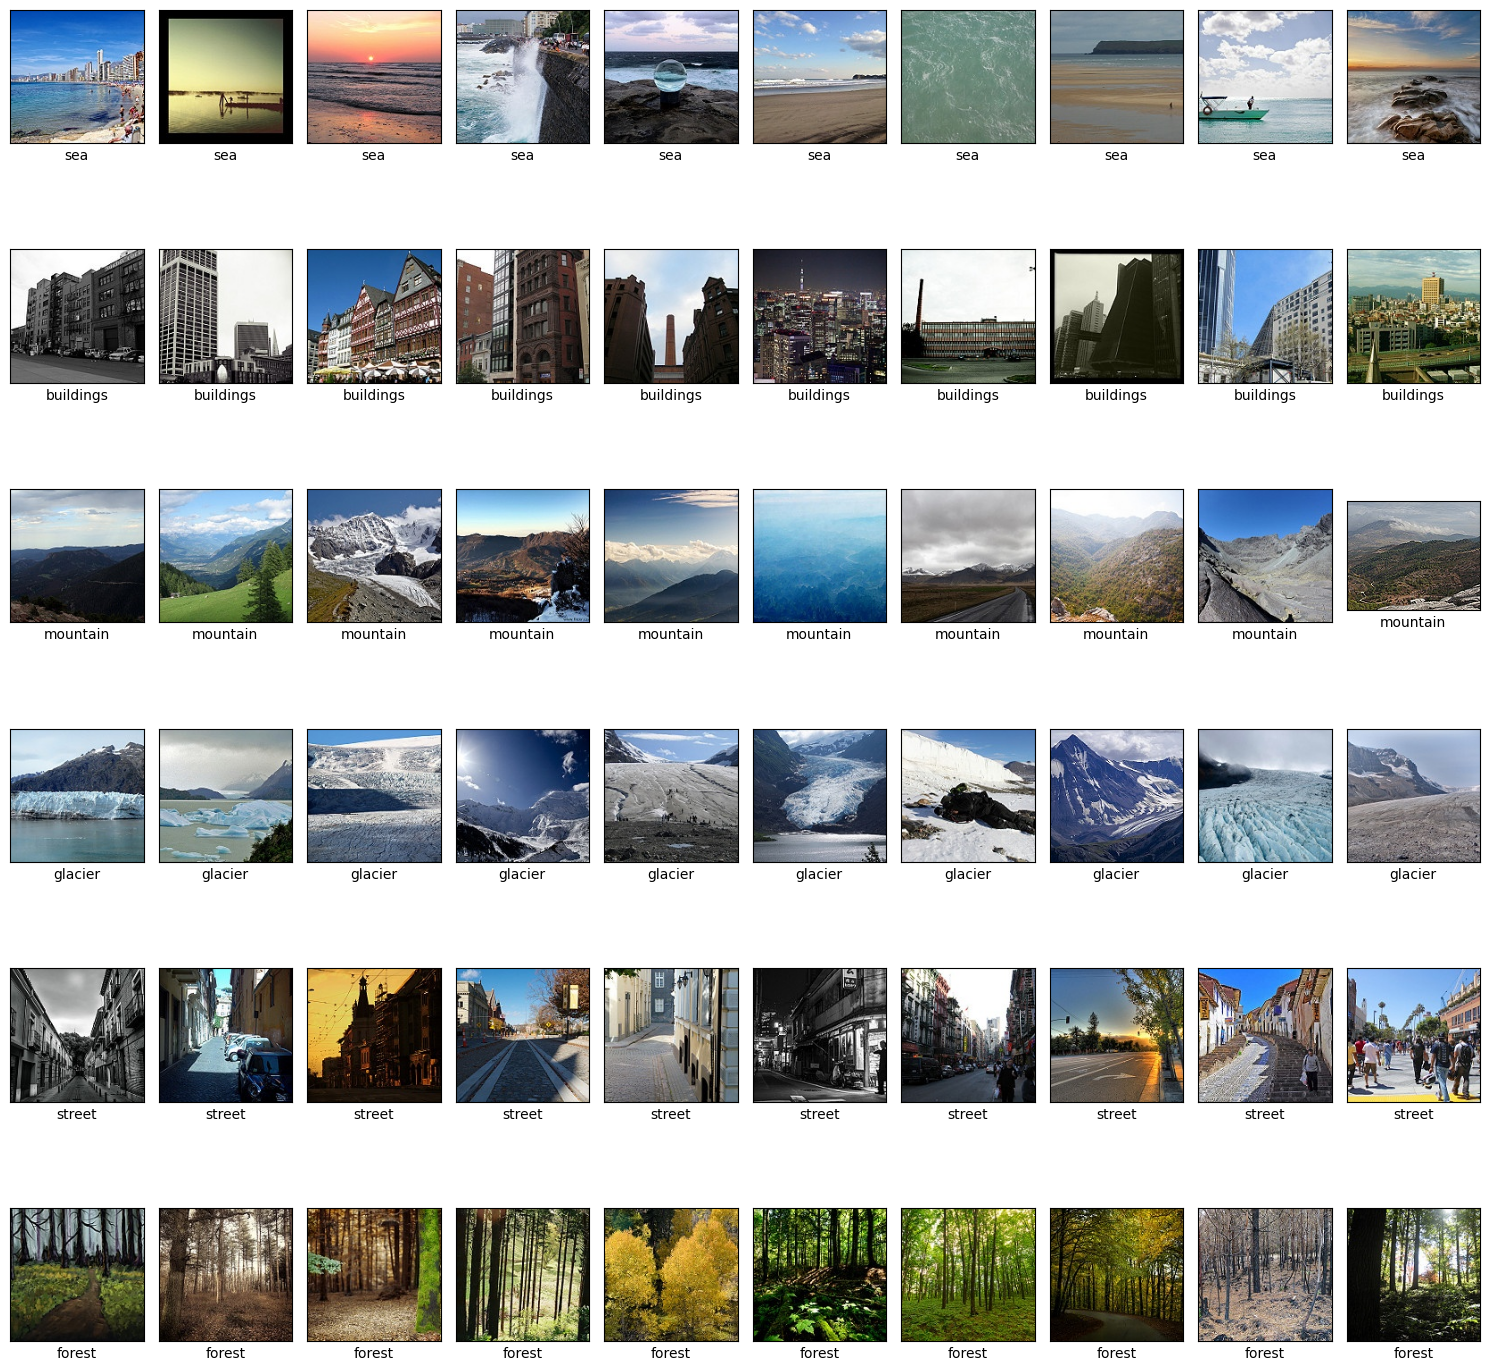

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
image_dir = {}

# Tentukan path sumber dataset
path = "/content/intel_dataset"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    image_dir[i] = os.listdir(os.path.join(path_sub, i))

path_sub = "/content/intel_dataset/dataset"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(image_dir.keys()), 10, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(image_dir[class_name], 10, replace=False)

    for j, image_name in enumerate(images):
      img_path = os.path.join(path_sub, class_name, image_name)
      img = Image.open(img_path)
      axs[i, j].imshow(img, cmap='gray')
      axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

**Plot Distribusi Semua Kelas**

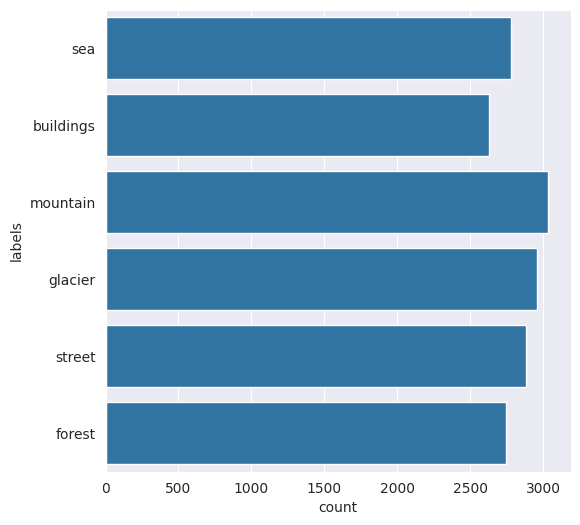

In [ ]:
# Path sumber data
image_path = "/content/intel_dataset/dataset"

# Daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(image_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train["labels"]

plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

**Data Augmentation**

In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.rot90(img, k=random.randint(1, 4))  # Rotasi 90, 180, atau 270 derajat secara acak
    return img

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))  # Sesuaikan nilai delta sesuai kebutuhan
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter shearing range
    datagen = ImageDataGenerator(shear_range=0.2)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = tf.image.resize(img, (224, 224))
    # Buat objek ImageDataGenerator dengan parameter width_shift_range dan height_shift_range
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
    img = next(iter(datagen.flow(tf.expand_dims(img, 0))))[0]
    return img

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_normal = "/content/intel_dataset/dataset"  # Path gambar asli
images_augmented = "/content/intel_dataset/dataset_augmented"  # Path folder gambar augmentasi
images = []  # Menyimpan gambar setelah preprocessing

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for root, dirs, files in os.walk(images_normal):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            images.append(os.path.join(root, file))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 7000
i = 1

while i <= images_to_generate:
    image_picture = random.choice(images)
    try:
        original_image = io.imread(image_picture)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        # Mengambil nama folder (label) dari gambar asli
        label = os.path.basename(os.path.dirname(image_picture))
        label_folder = os.path.join(images_augmented, label)
        os.makedirs(label_folder, exist_ok=True)

        new_image_path= os.path.join(label_folder, f"augmented_image_{i}.jpg")
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

Streaming output truncated to the last 5000 lines.
Could not read or process the image <module 'keras._tf_keras.keras.preprocessing.image' from '/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/preprocessing/image/__init__.py'> : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image <module 'keras._tf_keras.keras.preprocessing.image' from '/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/preprocessing/image/__init__.py'> : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image <module 'keras._tf_keras.keras.preprocessing.image' from '/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/preprocessing/image/__init__.py'> : Images of type float must be between -1 and 1. hence skipping it.
Could not read or process the image <module 'keras._tf_keras.keras.preprocessing.image' from '/usr/local/lib/python3.11/dist-packages/keras/_tf_keras/keras/preprocessing/image

In [ ]:
# Path folder asli dan folder augmentasi
images_normal = "/content/intel_dataset/dataset"
images_augmented = "/content/intel_dataset/dataset_augmented"
images_combined = "/content/intel_dataset/dataset_combined"

# Membuat folder gabungan
os.makedirs(images_combined, exist_ok=True)

# Menggabungkan subfolder (kelas)
for image_path_path in [images_normal, images_augmented]:
    for class_name in os.listdir(image_path):
        class_folder = os.path.join(image_path, class_name)
        if os.path.isdir(class_folder):
            target_class_folder = os.path.join(images_combined, class_name)
            os.makedirs(target_class_folder, exist_ok=True)

            for file_name in os.listdir(class_folder):
                src_file = os.path.join(class_folder, file_name)
                dst_file = os.path.join(target_class_folder, file_name)
                if not os.path.exists(dst_file):
                    shutil.copy2(src_file, dst_file)

#### Split Dataset

In [ ]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= '/content/intel_dataset/dataset_combined'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
buildings    2628
forest       2745
glacier      2957
mountain     3037
sea          2784
street       2883
dtype: int64

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 13627
test size 3407


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   buildings     510
       forest        567
       glacier       599
       mountain      615
       sea           554
       street        562
train  buildings    2118
       forest       2178
       glacier      2358
       mountain     2422
       sea          2230
       street       2321
dtype: int64 


                                                    path    labels    set
11906  /content/intel_dataset/dataset_combined/mounta...  mountain  train
8831   /content/intel_dataset/dataset_combined/glacie...   glacier  train
11706  /content/intel_dataset/dataset_combined/glacie...   glacier  train
11455  /content/intel_dataset/dataset_combined/forest...    forest  train
2665   /content/intel_dataset/dataset_combined/glacie...   glacier  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar
datasource_path = "/content/intel_dataset/dataset_combined"
# Membuat variabel Dataset, menampung data yang telah dilakukan split data training dan testing
dataset_path = "/content/intel_dataset/dataset-final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [ ]:
# Direktori train dan test
TRAIN_DIR = "/content/intel_dataset/dataset-final/train/"
TEST_DIR = "/content/intel_dataset/dataset-final/test/"

In [ ]:
# Membuat ImageDataGenerator untuk menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 10904 images belonging to 6 classes.
Found 2723 images belonging to 6 classes.
Found 3407 images belonging to 6 classes.


## Modelling

### Model 1 - CNN Architecture (Memakai 32, 64, 128, 256 Neurons di layer):

In [ ]:
model = Sequential([
    # Layer Konvolusi pertama
    Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer Konvolusi kedua
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer Konvolusi ketiga
    Conv2D(128, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer Konvolusi keempat
    Conv2D(256, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer GlobalAveragePooling2D
    GlobalAveragePooling2D(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dense(6, activation='softmax')
])

# Mengkompilasi model
model.compile(optimizer=Adam(learning_rate=0.0008),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,022 (2.01 MB)

 Trainable params: 524,550 (2.00 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
class StopAtAccuracy(Callback):
    def __init__(self, accuracy=0.92, val_accuracy=0.87):
        super(StopAtAccuracy, self).__init__()
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy

    def on_epoch_end(self, epoch, logs=None):
      train_accuracy = logs.get("accuracy")
      val_accuracy = logs.get("val_accuracy")
      if train_accuracy is not None and val_accuracy is not None:
        if train_accuracy >= self.accuracy and val_accuracy >= self.val_accuracy:
          print(f"\nTarget telah tercapai, Akurasi Pelatihan = {train_accuracy*100:.2f}%, Akurasi Validasi = {val_accuracy*100:.2f}%")
          self.model.stop_training = True

In [ ]:
stop_at_accuracy= StopAtAccuracy(accuracy=0.92, val_accuracy=0.87)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Train Model
history = model.fit(
    train_generator,
    epochs=100,
    batch_size=32,
    validation_data=validation_generator,
    callbacks=[stop_at_accuracy, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.5562 - loss: 1.1297 - val_accuracy: 0.3526 - val_loss: 2.3132 - learning_rate: 8.0000e-04
Epoch 2/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.7295 - loss: 0.7439 - val_accuracy: 0.6592 - val_loss: 0.9802 - learning_rate: 8.0000e-04
Epoch 3/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.7631 - loss: 0.6420 - val_accuracy: 0.6732 - val_loss: 0.9710 - learning_rate: 8.0000e-04
Epoch 4/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.8064 - loss: 0.5285 - val_accuracy: 0.7051 - val_loss: 0.7916 - learning_rate: 8.0000e-04
Epoch 5/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.8230 - loss: 0.4865 - val_accuracy: 0.7378 - val_loss: 0.6892 - learning_rate: 8.0000e-04
Epoch 6/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.8453 - loss: 0.4428 - val_accuracy: 0.7102 - val_loss: 0.7275 - learning_rate: 8.0000e-04
Epoch 7/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - a

### Model 2 - CNN Architecture (Memakai 64 Neurons di layer):

In [ ]:
model_2 = Sequential([
    # Layer Konvolusi pertama
    Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer Konvolusi kedua
    Conv2D(64, (4, 4), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer Konvolusi ketiga
    Conv2D(64, (7, 7), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer GlobalAveragePooling2D
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Mengkompilasi model
model_2.compile(optimizer=Adam(learning_rate=0.0008),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 37, 64)     │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,150 (1.09 MB)

 Trainable params: 285,638 (1.09 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
class EarlyStop(Callback):
    def __init__(self, accuracy=0.92, val_accuracy=0.88):
        super(EarlyStop, self).__init__()
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy

    def on_epoch_end(self, epoch, logs=None):
      train_accuracy = logs.get("accuracy")
      val_accuracy = logs.get("val_accuracy")
      if train_accuracy is not None and val_accuracy is not None:
        if train_accuracy >= self.accuracy and val_accuracy >= self.val_accuracy:
          print(f"\nTarget telah tercapai, Akurasi Pelatihan = {train_accuracy*100:.2f}%, Akurasi Validasi = {val_accuracy*100:.2f}%")
          self.model.stop_training = True

In [ ]:
early_stop = EarlyStop(accuracy=0.92, val_accuracy=0.88)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Train Model
history_2 = model_2.fit(
    train_generator,
    epochs=100,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.3784 - loss: 1.5386 - val_accuracy: 0.2740 - val_loss: 1.5709 - learning_rate: 8.0000e-04
Epoch 2/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.5832 - loss: 1.0417 - val_accuracy: 0.5913 - val_loss: 0.9585 - learning_rate: 8.0000e-04
Epoch 3/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.6876 - loss: 0.8498 - val_accuracy: 0.5619 - val_loss: 1.0431 - learning_rate: 8.0000e-04
Epoch 4/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.7464 - loss: 0.7152 - val_accuracy: 0.7595 - val_loss: 0.6823 - learning_rate: 8.0000e-04
Epoch 5/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.7710 - loss: 0.6624 - val_accuracy: 0.7172 - val_loss: 0.7826 - learning_rate: 8.0000e-04
Epoch 6/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.7938 - loss: 0.6030 - val_accuracy: 0.5641 - val_loss: 1.3705 - learning_rate: 8.0000e-04
Epoch 7/100
341/341 ━━━━━━━━━━━━━━━━━━━━ 17s 5

## Evaluasi dan Visualisasi

**Evaluasi Model 1**

In [ ]:
# Evaluasi Nilai
train_loss, train_accuracy = model.evaluate(train_generator)
test_loss, test_accuracy = model.evaluate(test_generator)

# Cetak hasil evaluasi
print(f"Akurasi pada data Training: {train_accuracy:4f}")
print(f"Akurasi pada data Testing : {test_accuracy:4f}")

341/341 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9930 - loss: 0.0307
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8955 - loss: 0.3606
Akurasi pada data Training: 0.991838
Akurasi pada data Testing : 0.890226


**Evaluasi Model 2**

In [ ]:
# Evaluasi Nilai
train_loss, train_accuracy = model_2.evaluate(train_generator)
test_loss, test_accuracy = model_2.evaluate(test_generator)

# Cetak hasil evaluasi
print(f"Akurasi pada data Training: {train_accuracy:4f}")
print(f"Akurasi pada data Testing : {test_accuracy:4f}")

341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9461 - loss: 0.1556
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8912 - loss: 0.3055
Akurasi pada data Training: 0.945341
Akurasi pada data Testing : 0.893455


In [ ]:
# Hasil evaluasi Model 1
train_accuracy_1 = 0.9918
test_accuracy_1 = 0.8902

# Hasil evaluasi Model 2
train_accuracy_2 = 0.9453
test_accuracy_2 = 0.8934

# Membuat data untuk DataFrame
data = {
    'Model': ['Model 1 CNN', 'Model 2 CNN'],
    'Train Accuracy': [train_accuracy_1, train_accuracy_2],
    'Test Accuracy': [test_accuracy_1, test_accuracy_2]
}

# Membuat DataFrame
df_comparison = pd.DataFrame(data)

# Menampilkan DataFrame
print(df_comparison)

         Model  Train Accuracy  Test Accuracy
0  Model 1 CNN          0.9918         0.8902
1  Model 2 CNN          0.9453         0.8934


**Plot dari Model 1**

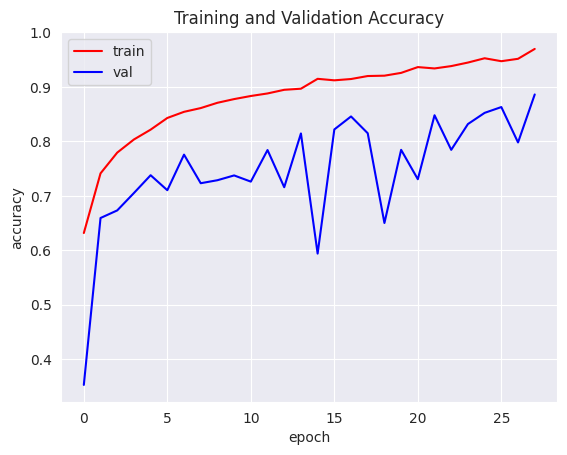

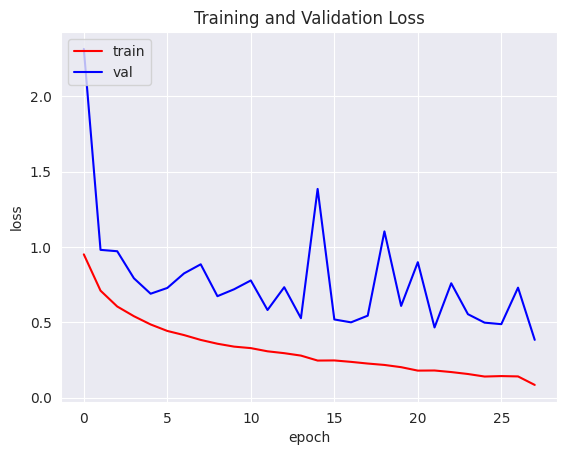

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

**Plot dari Model 2**

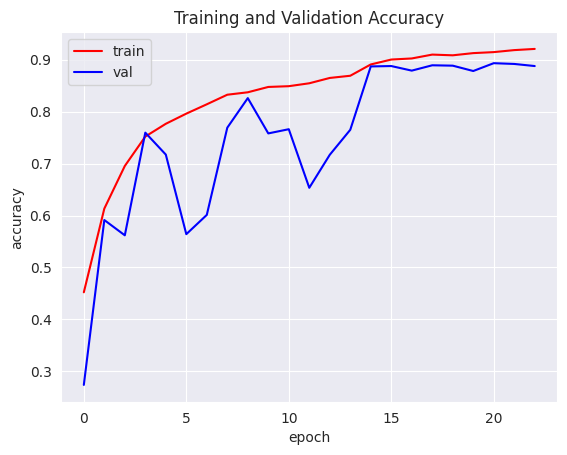

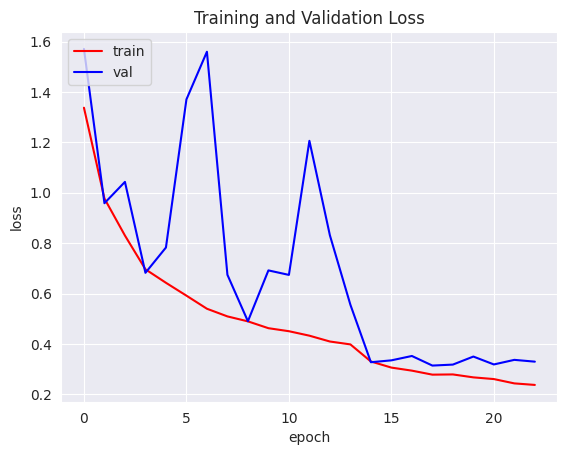

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_labels = list(train_generator.class_indices.keys())
print("Kelas yang terdeteksi pada dataset:", class_labels)

Kelas yang terdeteksi pada dataset: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


3407/3407 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step


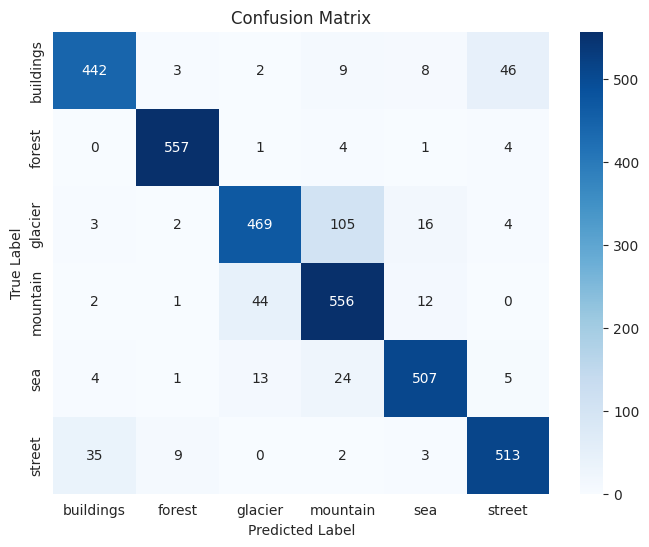


Classification Report:
              precision    recall  f1-score   support

   buildings     0.9095    0.8667    0.8876       510
      forest     0.9721    0.9824    0.9772       567
     glacier     0.8866    0.7830    0.8316       599
    mountain     0.7943    0.9041    0.8456       615
         sea     0.9269    0.9152    0.9210       554
      street     0.8969    0.9128    0.9048       562

    accuracy                         0.8935      3407
   macro avg     0.8977    0.8940    0.8946      3407
weighted avg     0.8958    0.8935    0.8933      3407



In [ ]:
test_generator.reset()

# Melakukan Prediksi kelas menggunakan model 2
pred_probs = model_2.predict(test_generator, verbose=1)

# Mengambil prediksi label (kelas dengan probabilitas tertinggi)
y_pred = np.argmax(pred_probs, axis=1)

# Label aktual dari generator
y_true = test_generator.classes

# Daftar Nama kelas dari generator
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

**Insight:**

- Performa pada Data Training: Model 1 CNN menunjukkan akurasi yang jauh lebih tinggi pada data training (0.9918 atau sekitar 99.18%) dibandingkan dengan Model 2 CNN (0.9453 atau sekitar 94.53%). Ini mengindikasikan bahwa Model 1 belajar data training dengan sangat baik, bahkan mungkin terlalu baik sehingga ada potensi overfitting.

- Performa pada Data Testing: Pada data testing, performa kedua model lebih mirip. Model 2 CNN menunjukkan akurasi yang sedikit lebih tinggi (0.8934 atau sekitar 89.35%) dibandingkan dengan Model 1 CNN (0.8902 atau sekitar 89.02%). Perbedaannya memang tidak signifikan, tetapi Model 2 memiliki sedikit keunggulan dalam kemampuan generalisasi ke data yang belum pernah dilihat  karena hasil belajar pada data training yang tidak terlalu tinggi atau jarak antara data training dan testing tidak terlalu jauh.

Jadi, Model yang akan disimpan dan digunakan adalah **Model 2 CNN (3 Layer Konvolusi dengan 64 Neuron)**

## Konversi Model

**Menyimpan Model 2**

In [ ]:
model_2.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_18')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138924681461840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138924681542352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138924681543504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138924681541392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138924681543120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138924681530640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138924681542928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138924681543312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923142867152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923142868496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923142860816:

In [ ]:
from google.colab import files

!zip -r saved_model.zip saved_model//
files.download('saved_model.zip')

  adding: saved_model// (stored 0%)
  adding: saved_model//saved_model.pb (deflated 88%)
  adding: saved_model//fingerprint.pb (stored 0%)
  adding: saved_model//variables/ (stored 0%)
  adding: saved_model//variables/variables.index (deflated 72%)
  adding: saved_model//variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model//assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **TFJS**

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model \
    tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-22 05:17:18.107794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745299038.128396   19605 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [ ]:
!zip -r tfjs_model.zip tfjs_model/
files.download('tfjs_model.zip')

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 91%)
  adding: tfjs_model/group1-shard1of1.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
saved_model_path = 'saved_model'
tflite_path = 'tflite/model.tflite'
label_path = 'tflite/label.txt'

# Buat folder output jika belum ada
os.makedirs(os.path.dirname(tflite_path), exist_ok=True)

# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Simpan model .tflite
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model TFLite berhasil disimpan di: {tflite_path}")

# Gunakan class_labels untuk membuat mengecek dan membuat label.txt
try:
    class_labels
except NameError:
    class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    print("'class_labels' tidak ditemukan.")

# Simpan label ke file
with open(label_path, 'w') as f:
    for label in class_labels:
        f.write(label + '\n')
print(f"Label kelas berhasil disimpan di: {label_path}")

Model TFLite berhasil disimpan di: tflite/model.tflite
Label kelas berhasil disimpan di: tflite/label.txt


In [ ]:
!zip -r tflite.zip tflite/
files.download('tflite.zip')

  adding: tflite/ (stored 0%)
  adding: tflite/label.txt (deflated 4%)
  adding: tflite/model.tflite (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


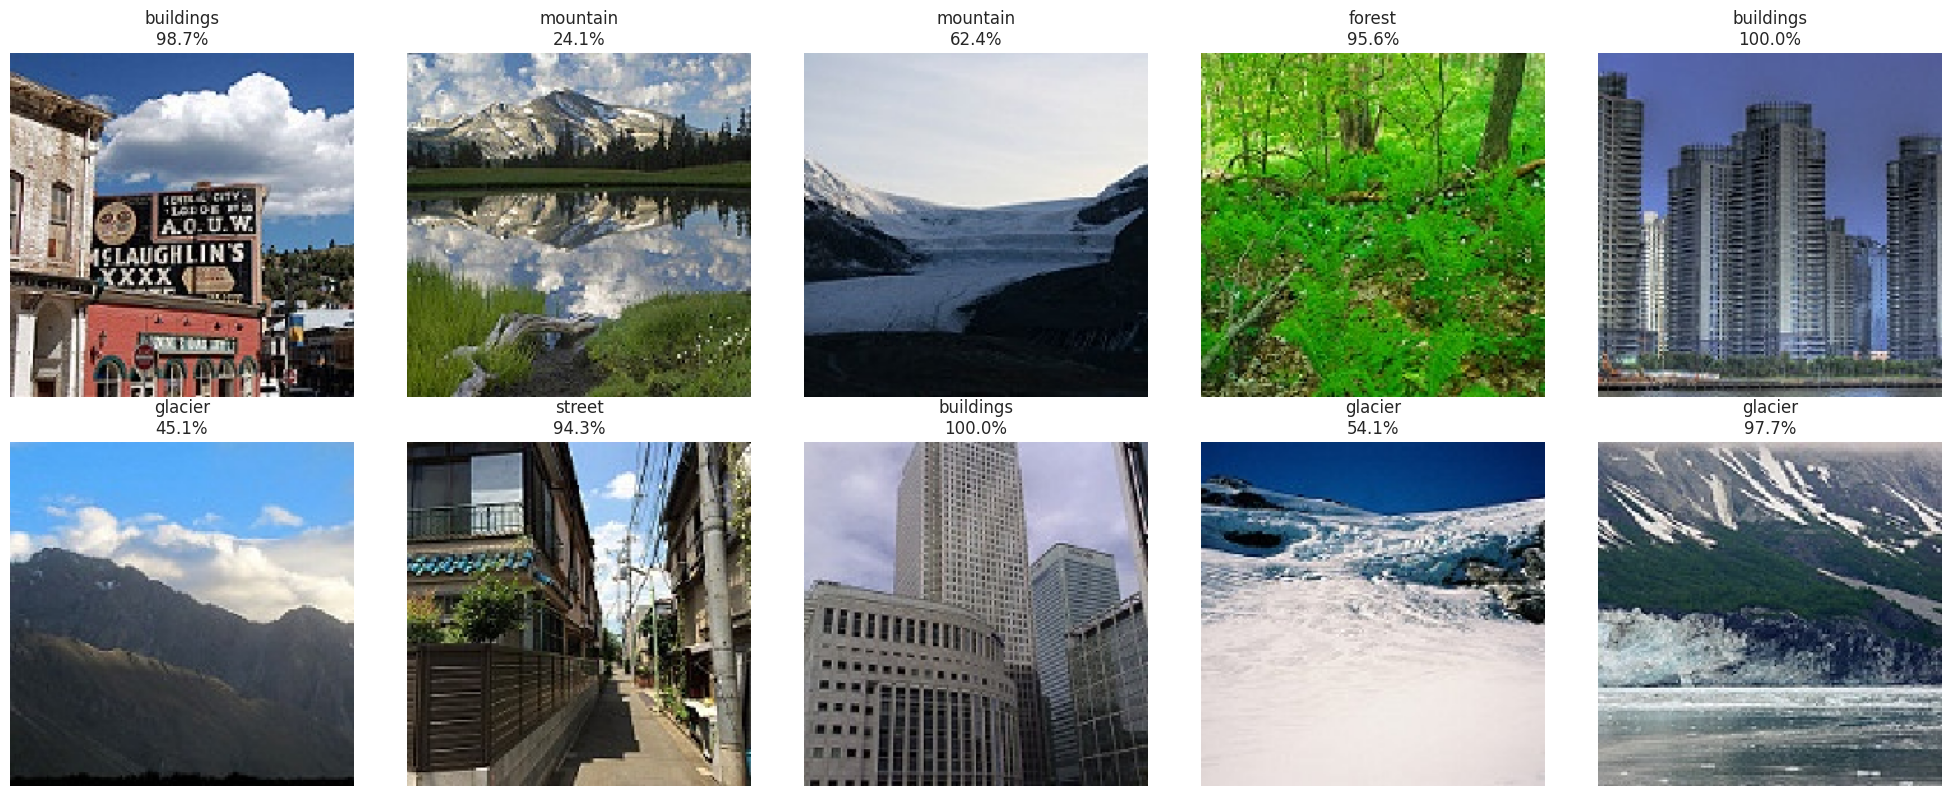

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Gambar ke-1: 11895.jpg
Prediksi: buildings
Confidence per class:
  buildings : 98.73%
  forest    : 0.00%
  glacier   : 0.05%
  mountain  : 0.00%
  sea       : 0.01%
  street    : 1.20%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Gambar ke-2: 2593.jpg
Prediksi: mountain
Confidence per class:
  buildings : 22.79%
  forest    : 7.96%
  glacier   : 23.69%
  mountain  : 24.07%
  sea       : 5.82%
  street    : 15.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Gambar ke-3: 5383.jpg
Prediksi: mountain
Confidence per class:
  buildings : 0.16%
  forest    : 0.85%
  glacier   : 29.33%
  mountain  : 62.45%
  sea       : 6.92%
  street    : 0.29%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Gambar ke-4: 9477.jpg
Prediksi: forest
Confidence per class:
  buildings : 0.94%
  forest    : 95.64%
  glacier   : 2.27%
  mountain  : 0.23%
  sea       : 0.13%
  street    : 0.79%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Gambar ke-5: 8080.jpg
Prediksi: buildings
Confidence per class:
 

In [ ]:
# Mengambil 10 file gambar secara acak dari folder prediksi
image_folder = '/content/seg_pred/seg_pred'
all_image_files = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpg')]
random_image_files = random.sample(all_image_files, 10)

# Visualisasi dan prediksi
plt.figure(figsize=(20, 8))

for i, img_path in enumerate(random_image_files):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    pred = model_2.predict(img_array)
    predicted_class = class_labels[np.argmax(pred)]

    # Menampilkan gambar
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{predicted_class}\n{np.max(pred)*100:.1f}%')

plt.tight_layout()
plt.show()

# Menampilkan confidence detail untuk setiap gambar
for i, img_path in enumerate(random_image_files):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model_2.predict(img_array)
    predicted_class = class_labels[np.argmax(pred)]

    print(f'\nGambar ke-{i+1}: {os.path.basename(img_path)}')
    print(f'Prediksi: {predicted_class}')
    print("Confidence per class:")
    for j, label in enumerate(class_labels):
        print(f"  {label:10s}: {pred[0][j]*100:.2f}%")

**Inference Menggunakan TFLite**

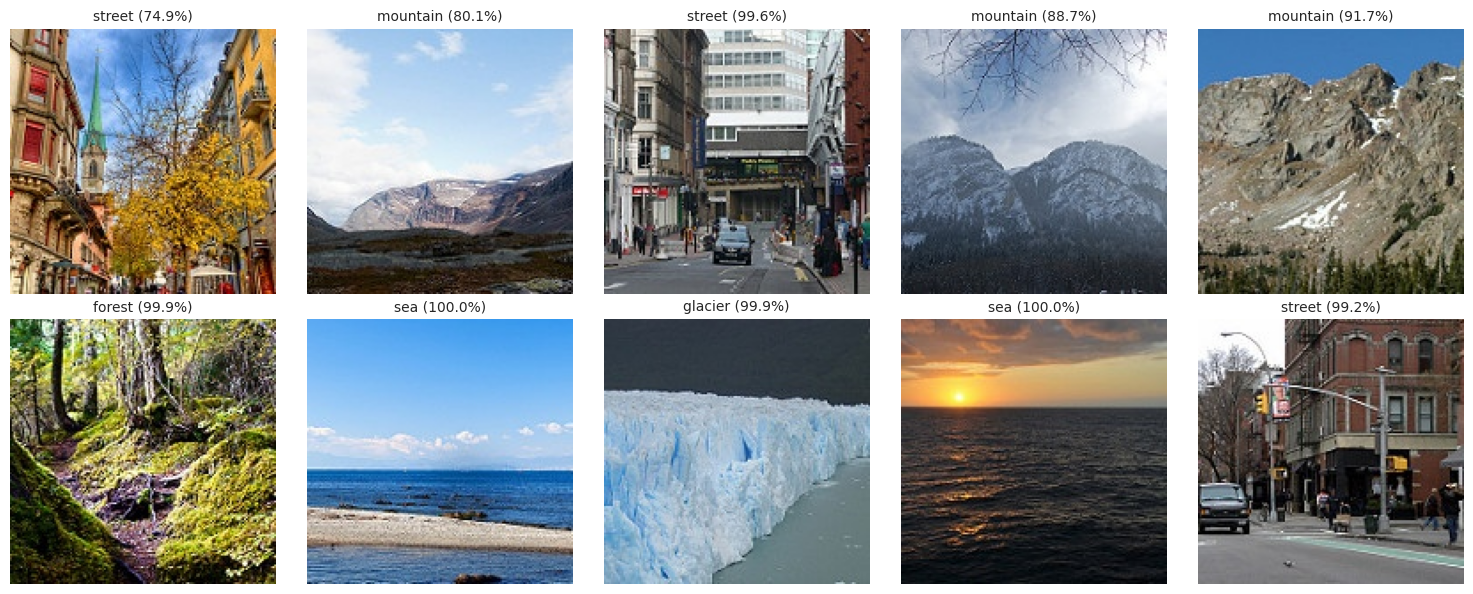

In [ ]:
# Path ke direktori gambar
image_dir = "/content/seg_pred/seg_pred"

# Format gambar
image_extensions = ['.jpg', '.jpeg', '.png']

# Ambil file gambar yang valid
image_files = [f for f in os.listdir(image_dir) if any(f.endswith(ext) for ext in image_extensions)]
image_files = sorted(image_files)[:10]

# Load model tflite
interpreter = tf.lite.Interpreter(model_path="/content/tflite/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load label dari label.txt
with open("/content/tflite/label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Proses dan visualisasi gambar
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)

    img = Image.open(image_path).resize((150, 150))
    img_array = np.array(img).astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_details[0]['index'])[0]

    predicted_index = np.argmax(pred)
    predicted_label = labels[predicted_index]
    confidence = pred[predicted_index] * 100

    axes[idx].imshow(img)
    axes[idx].set_title(f"{predicted_label} ({confidence:.1f}%)", fontsize=10)
    axes[idx].axis('off')

# Menghentikan sisa subplot
for j in range(len(image_files), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pipreqs

In [ ]:
!pipreqs --scan-notebook '/content/drive/MyDrive/Colab Notebooks/Proyek Akhir Klasifikasi Gambar'

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/Colab Notebooks/Proyek Akhir Klasifikasi Gambar/requirements.txt
